<a href="https://colab.research.google.com/github/swaraj0009/Melanoma-Skin-Cancer-Detection-Swaraj-Assign/blob/main/Swarajkumar_MelanomaSkinCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/sample_data/CNN_assignment.zip" > /dev/null

unzip:  cannot find or open /content/sample_data/CNN_assignment.zip, /content/sample_data/CNN_assignment.zip.zip or /content/sample_data/CNN_assignment.zip.ZIP.


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

Found 2239 files belonging to 9 classes.


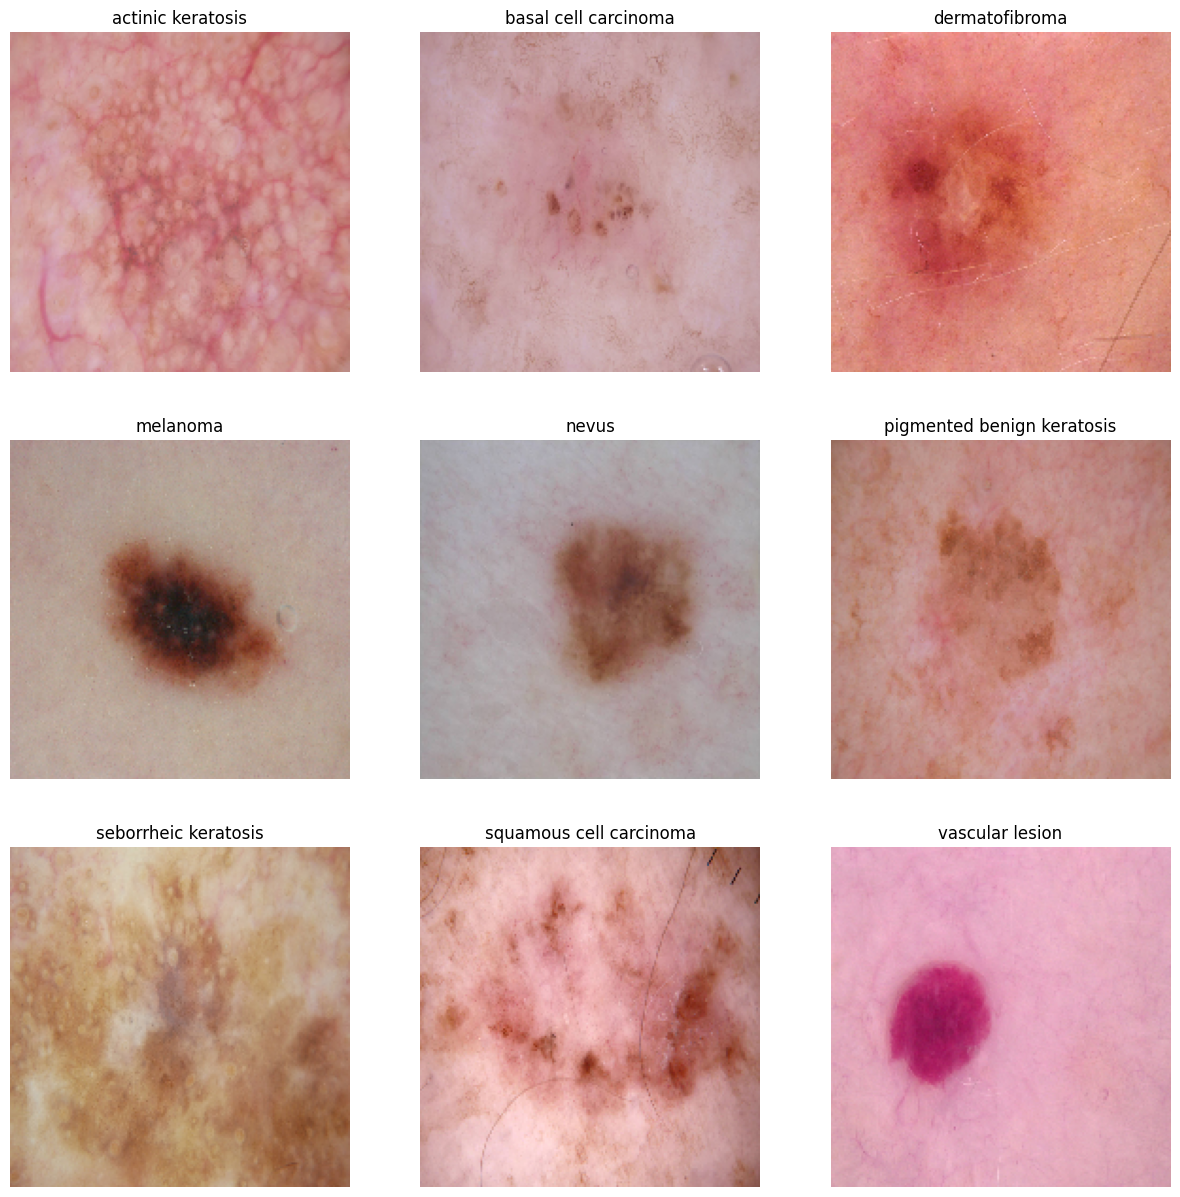

In [ ]:
# Create image dataset from directory
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123
)

# Get class names from the image dataset
class_names = image_dataset.class_names

# Dictionary to store image paths per class
files_path_dict = {c: [str(data_dir_train) + '/' + c + '/' + x for x in os.listdir(str(data_dir_train) + '/' + c)] for c in class_names}

# Visualize one image per class
plt.figure(figsize=(15, 15))
for index, c in enumerate(class_names, 1):
    path_list = files_path_dict[c][:1]
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0], target_size=(img_height, img_width)))
    plt.title(c)
    plt.axis("off")

### Explore the distribution of classes within the training dataset visually.

In [ ]:
def class_distribution_count(directory):
    # Count number of images in each class
    counts = []
    sub_directories = []

    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            sub_directory_name = path.name
            sub_directories.append(sub_directory_name)
            count = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
            counts.append(count)

    # Create a DataFrame with image count and class name
    df = pd.DataFrame({'Class': sub_directories, 'No. of Image': counts})
    return df

# Call the function with the data directory
df = class_distribution_count(data_dir_train)
print(df)

                        Class  No. of Image
0           actinic keratosis           114
1              dermatofibroma            95
2        basal cell carcinoma           376
3                    melanoma           438
4                       nevus           357
5        seborrheic keratosis            77
6     squamous cell carcinoma           181
7             vascular lesion           139
8  pigmented benign keratosis           462


<Axes: xlabel='No. of Image', ylabel='Class'>

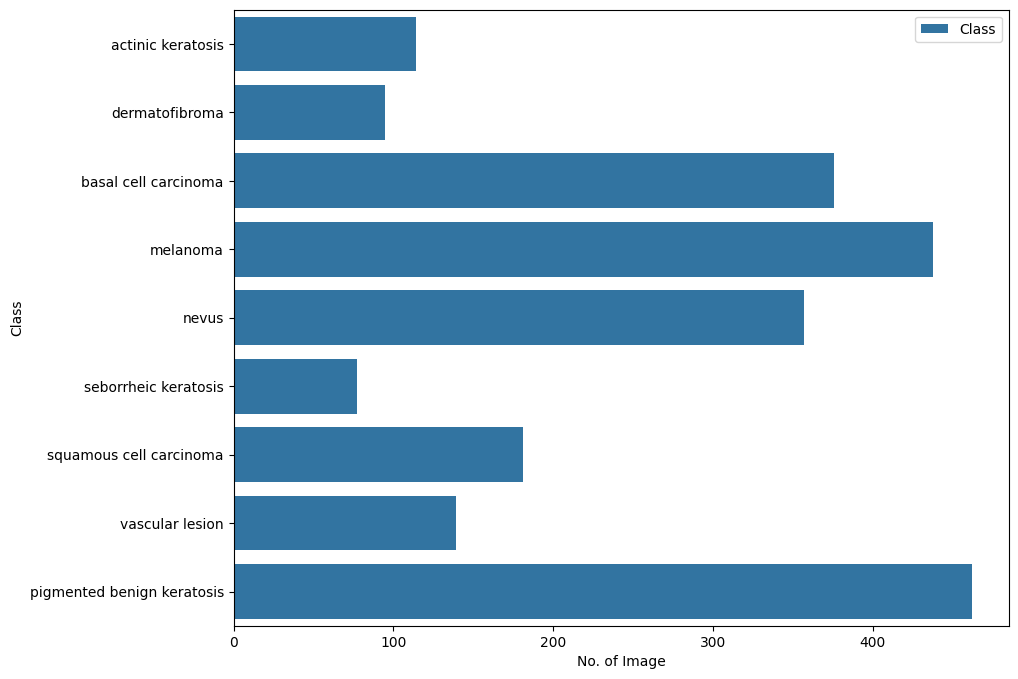

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### To address the issue of class imbalance,

#### we can utilize the Augmentor Python package (https://augmentor.readthedocs.io/en/master/) to augment the dataset by generating additional samples for all classes.

#### This approach aims to ensure that none of the classes have a disproportionately low number of samples.

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
import pathlib

# Define the path to the training dataset
training_dataset_path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

# Loop through each class in the dataset
for class_name in class_names:
    # Create an Augmentor pipeline for the current class
    p = Augmentor.Pipeline(str(training_dataset_path / class_name))  # Convert pathlib.Path to string and concatenate

    # Apply rotation augmentation with a probability of 0.7 and specified rotation angles
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Generate 500 augmented samples for the current class
    p.sample(500)

Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7938A32A30A0>: 100%|██████████| 500/500 [00:43<00:00, 11.51 Samples/s]


Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7938A6F3AE00>: 100%|██████████| 500/500 [00:29<00:00, 16.88 Samples/s]


Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=6648x4439 at 0x7938A713C580>: 100%|██████████| 500/500 [10:58<00:00,  1.32s/ Samples]


Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1022x767 at 0x7938A6DACA60>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1022x767 at 0x7938A713C580>: 100%|██████████| 500/500 [00:55<00:00,  9.05 Samples/s]


Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7938A9D3FFD0>: 100%|██████████| 500/500 [00:26<00:00, 18.85 Samples/s]


Initialised with 3 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7938BBF91900>: 100%|██████████| 500/500 [00:51<00:00,  9.75 Samples/s]


Initialised with 16 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=6668x4419 at 0x7938A6EB0910>: 100%|██████████| 500/500 [10:45<00:00,  1.29s/ Samples]


Initialised with 3 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7938A6EB3DF0>: 100%|██████████| 500/500 [00:26<00:00, 18.60 Samples/s]


In [ ]:
image_count_train = len(list(training_dataset_path.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Building the Model

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#The CNN model architecture involves using the Sequential approach,
# which enables the creation of models layer by layer.

model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

#First convolutional layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second convolutional Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third convolutional Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#The Dropout layer is configured to drop 50%# of the input units.
model.add(layers.Dropout(0.5))

#The Flatten layer in Keras, achieved through the Keras.layers.flatten function,
#converts multi-dimensional input tensors into a single dimension.

model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

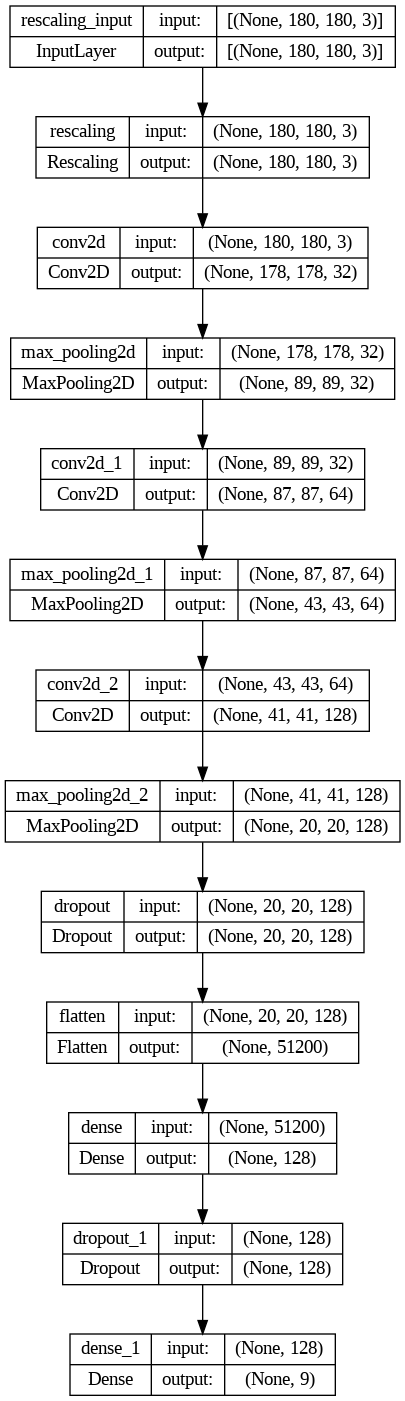

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Model Compilation

#Adam optimization: Utilizes a stochastic gradient descent technique, incorporating adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Employed as the loss function in multi-class classification models with two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.1082 - accuracy: 0.2037
Epoch 1: val_accuracy improved from -inf to 0.25503, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 200s 4s/step - loss: 2.1082 - accuracy: 0.2037 - val_loss: 1.9274 - val_accuracy: 0.2550
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7495 - accuracy: 0.3912
Epoch 2: val_accuracy improved from 0.25503 to 0.37808, saving model to model.h5
56/56 [==============================] - 147s 3s/step - loss: 1.7495 - accuracy: 0.3912 - val_loss: 1.7168 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5628 - accuracy: 0.4509
Epoch 3: val_accuracy improved from 0.37808 to 0.45638, saving model to model.h5
56/56 [==============================] - 146s 3s/step - loss: 1.5628 - accuracy: 0.4509 - val_loss: 1.5203 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.4572 - accuracy: 0.4933
Epoch 4: val_accuracy improved from 0.45638 to 0.52349, saving model to model.h5
56/56 [==============================] - 152s 3s/step - loss: 1.4572 - accuracy: 0.49

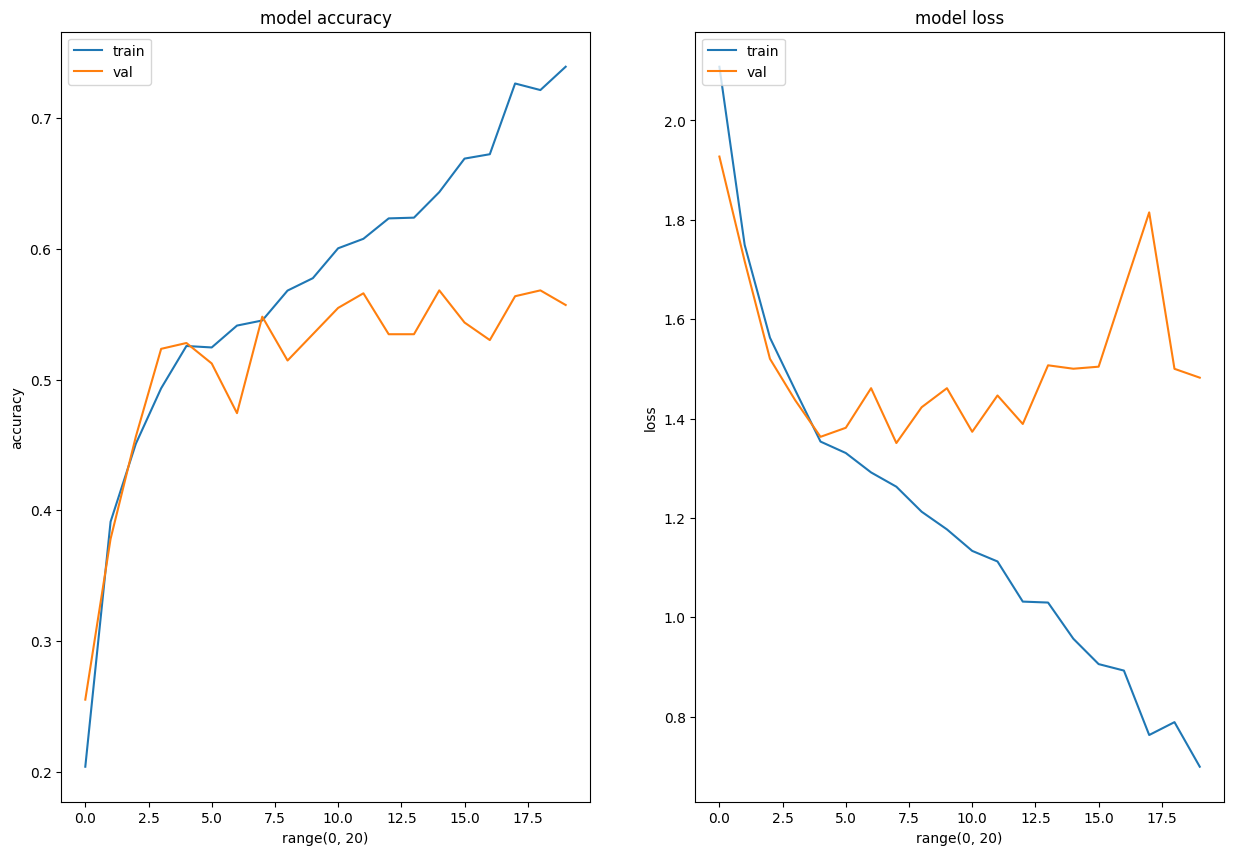

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Model Prediction

1/1 [==============================] - 0s 200ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


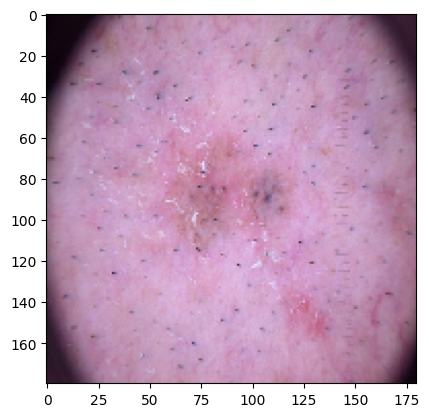

In [ ]:
from glob import glob
import os

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_images = glob(Test_image_path)
Test_images = [img_path for img_path in Test_images if os.path.isfile(img_path)]  # Filter out directories

if Test_images:  # Check if there are any image files
    Test_image = load_img(Test_images[-1], target_size=(img_height, img_width, 3))
    plt.imshow(Test_image)
    plt.grid(False)

    img = np.expand_dims(Test_image, axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    print("Actual Class " + class_names[1] + '\n' + "Predictive Class " + pred_class)
else:
    print("No image files found in the specified directory.")